In [23]:
input_default_json_conf_file='cnn_emotion4_kfold_default.json';

In [24]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import datetime
import json

In [25]:
import sys
sys.path.append('../library');

In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
## Load json conf json file
fd = open(os.path.join('./',input_default_json_conf_file));
DATA = json.load(fd);
fd.close()

# Variable globales

In [27]:
## Seed for the random variables
seed_number = 0;

## Dataset 
dataset_base_dir    = DATA["dataset_base_dir"]; 
dataset_labels_file = DATA['dataset_labels_file'];
dataset_name        = DATA['dataset_name'];

## Kfold 
K                 = DATA["kfold"]; # Variable K of kfold
enable_stratified = DATA["enable_stratified"]; # True: Stratified kfold False: Enable kfold 

## Training hyperparameters
EPOCAS     = DATA["epochs"];
BATCH_SIZE = DATA["batch_size"];

## Model of network
## 'mobilenet_v3', 'efficientnet_b3', 'inception_v3', 'inception_resnet_v2', 'resnet_v2_50'
model_type = DATA["model_type"];

## Output
output_base_dir = DATA["output_base_dir"];

## Output json file
fold_status_file='kfold_data_results.json';

##############################################

#print('   dataset_base_dir:',dataset_base_dir)
#print('dataset_labels_file:',dataset_labels_file)
#print('       dataset_name:',dataset_name)
#print('         model_type:',model_type)
#print('                  K:',K)
#print('  enable_stratified:',enable_stratified)
#print('             EPOCAS:',EPOCAS)
#print('         BATCH_SIZE:',BATCH_SIZE)
#print('    output_base_dir:',output_base_dir)


# Parametros de entrada

In [28]:
for n in range(len(sys.argv)):
    if sys.argv[n]=='--dataset-dir':
        dataset_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-file':
        dataset_labels_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--model':
        model_type=sys.argv[n+1];
    elif sys.argv[n]=='--kfold':
        K=int(sys.argv[n+1]);
    elif sys.argv[n]=='--enable-stratified':
        enable_stratified=bool(sys.argv[n+1]);
    elif sys.argv[n]=='--epochs':
        EPOCAS=int(sys.argv[n+1]);
    elif sys.argv[n]=='--batch-size':
        BATCH_SIZE=int(sys.argv[n+1]);
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
        
print('   dataset_base_dir:',dataset_base_dir)
print('dataset_labels_file:',dataset_labels_file)
print('       dataset_name:',dataset_name)
print('         model_type:',model_type)
print('                  K:',K)
print('  enable_stratified:',enable_stratified)
print('             EPOCAS:',EPOCAS)
print('         BATCH_SIZE:',BATCH_SIZE)
print('    output_base_dir:',output_base_dir)

   dataset_base_dir: /media/fernando/Expansion/DATASET/TESE/PATIENT-RECOGNITION/PATIENT-IMAGES/perwi/dataset/train/
dataset_labels_file: labels-emotion4-v1.csv
       dataset_name: perwi
         model_type: mobilenet_v3
                  K: 5
  enable_stratified: True
             EPOCAS: 50
         BATCH_SIZE: 32
    output_base_dir: /media/fernando/Expansion/OUTPUTS/DOCTORADO2/cnn_emotion4/perwi_2


# Set seed of random variables


In [29]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Setting the cross-validation kfold


In [30]:
from sklearn.model_selection import KFold, StratifiedKFold

output_dir = os.path.join(output_base_dir,dataset_name,'cross-validation',model_type);

if enable_stratified:
    kf = StratifiedKFold(n_splits = K, shuffle = True, random_state = seed_number);
else:
    kf  = KFold(n_splits = K, shuffle=True, random_state=seed_number); 

# Loading data of dataset

In [31]:
# Load filenames and labels
train_val_data = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
print(train_val_data)
# Setting labels
Y   = train_val_data[['label']];
L=np.shape(Y)[0];

                   filename     label
0     patient/filename1.png  Negative
1     patient/filename2.png  Negative
2     patient/filename3.png      Pain
3     patient/filename4.png  Negative
4     patient/filename5.png      Pain
..                      ...       ...
626  people/filename349.png    Neutro
627  people/filename350.png    Neutro
628  people/filename351.png    Neutro
629  people/filename352.png    Neutro
630  people/filename354.png  Positive

[631 rows x 2 columns]


# Data augmentation configuration

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg    = ImageDataGenerator(rescale=1./255,
                            rotation_range = 10,
                            width_shift_range= 0.07,
                            height_shift_range= 0.07,
                            horizontal_flip=True,
                            shear_range=1.25,
                            zoom_range = [0.75, 1.25] 
                            )

idg_val= ImageDataGenerator(rescale=1./255 )



# Auxiliar function

In [33]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

# Creating output directory

In [34]:
os.makedirs(output_dir,exist_ok = True) 
print(output_dir)


/media/fernando/Expansion/OUTPUTS/DOCTORADO2/cnn_emotion4/perwi_2/perwi/mobilenet_v3


# Creating output status file

In [35]:
json_status_path=os.path.join(output_dir,fold_status_file);

# Cross-validation


Fold: 1
Loading architecture mobilenet_v3

        url: https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5
target_size: (224, 224)



2024-04-24 20:47:14.215649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 20:47:14.215760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 20:47:14.215838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1024)              1529968   
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 1534068 (5.85 MB)
Trainable params: 4100 (16.02 KB)
Non-trainable params: 1529968 (5.84 MB)
_________________________________________________________________
Found 504 validated image filenames belonging to 4 classes.
Found 127 validated image filenames belonging to 4 classes.


2024-04-24 20:47:16.843982: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


Epoch 1/50


2024-04-24 20:47:24.449892: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-04-24 20:47:24.713680: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-04-24 20:47:24.952353: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-04-24 20:47:25.434738: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-24 20:47:32.578508: I external/local_xla/xla/service/service.cc:168] XLA service 0x77b2993a8b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 20:47:32.578578: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-24 20:47:32.856480: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] d

 4/16 [======>.......................] - ETA: 1s - loss: 1.4551 - categorical_accuracy: 0.3047  

2024-04-24 20:47:34.444861: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


15/16 [===========================>..] - ETA: 0s - loss: 1.3640 - categorical_accuracy: 0.3538
Epoch 1: val_loss improved from inf to 1.24707, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/cnn_emotion4/perwi_2/perwi/mobilenet_v3/model_1.h5
16/16 [==============================] - 18s 390ms/step - loss: 1.3480 - categorical_accuracy: 0.3591 - val_loss: 1.2471 - val_categorical_accuracy: 0.4094
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 1.1136 - categorical_accuracy: 0.5040
Epoch 2: val_loss improved from 1.24707 to 1.18158, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/cnn_emotion4/perwi_2/perwi/mobilenet_v3/model_1.h5
16/16 [==============================] - 6s 353ms/step - loss: 1.1136 - categorical_accuracy: 0.5040 - val_loss: 1.1816 - val_categorical_accuracy: 0.4252
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.0344 - categorical_accuracy: 0.5337
Epoch 3: val_loss improved from 1.18158 to 1.14116, saving

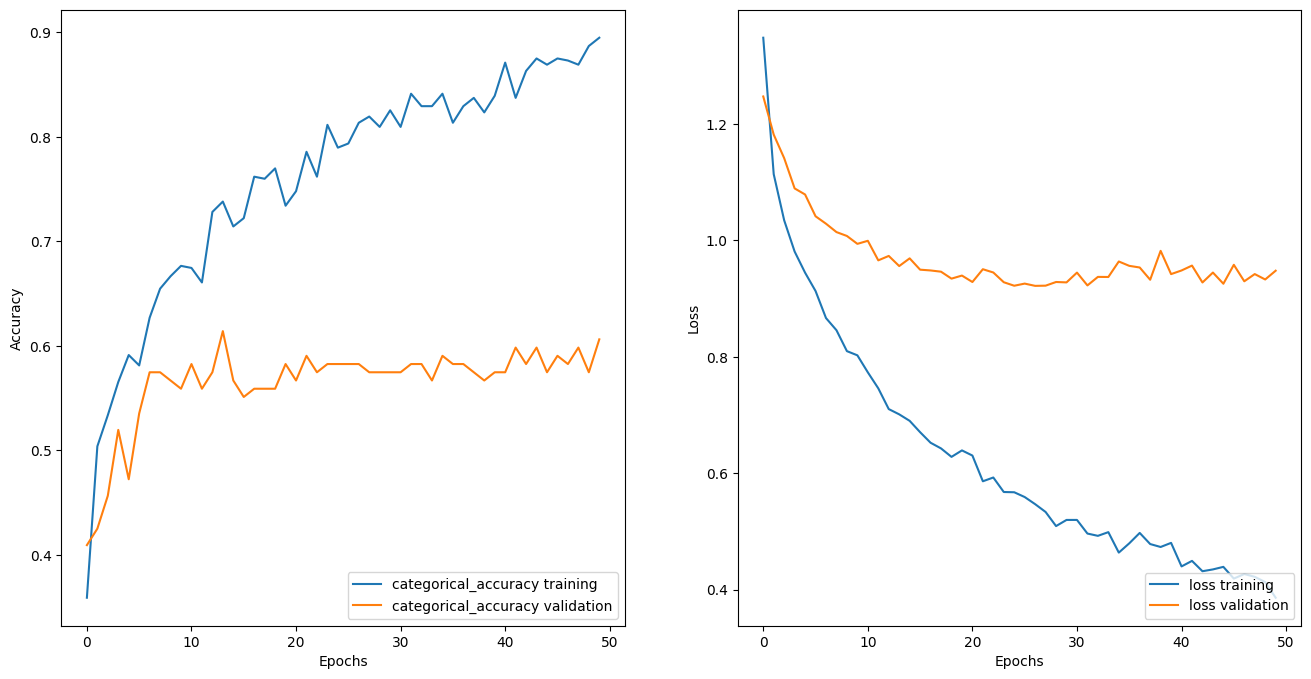

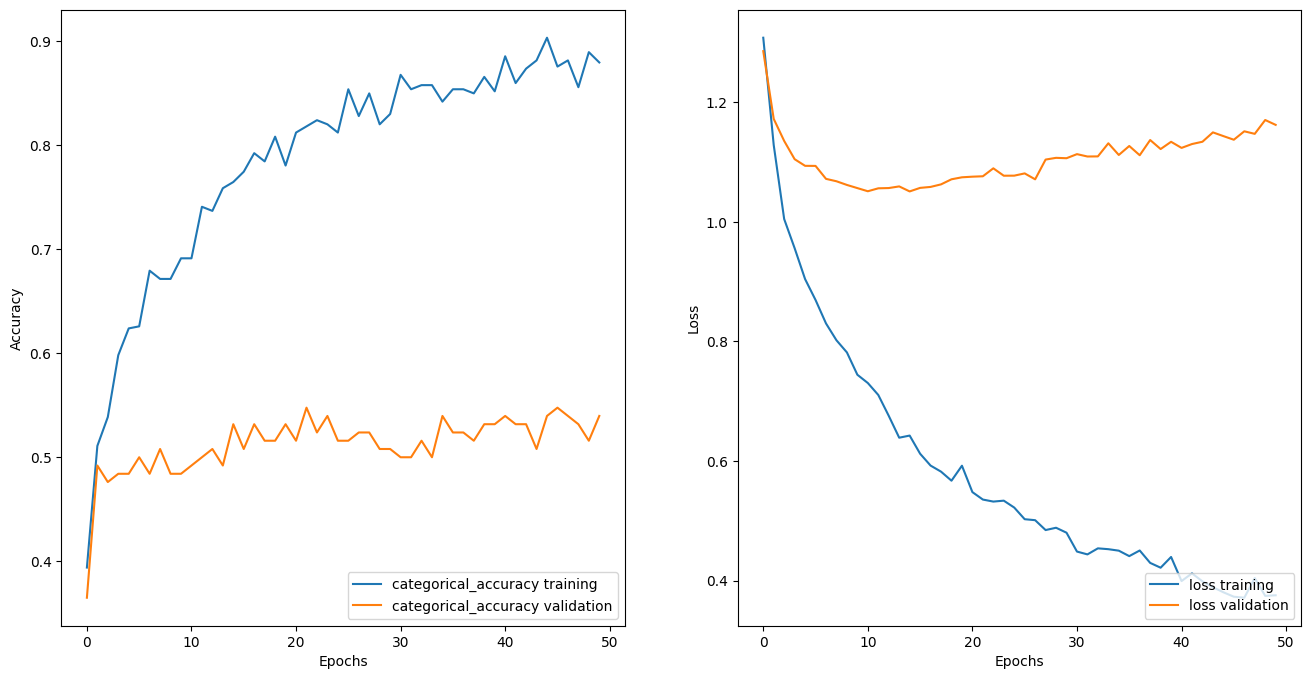

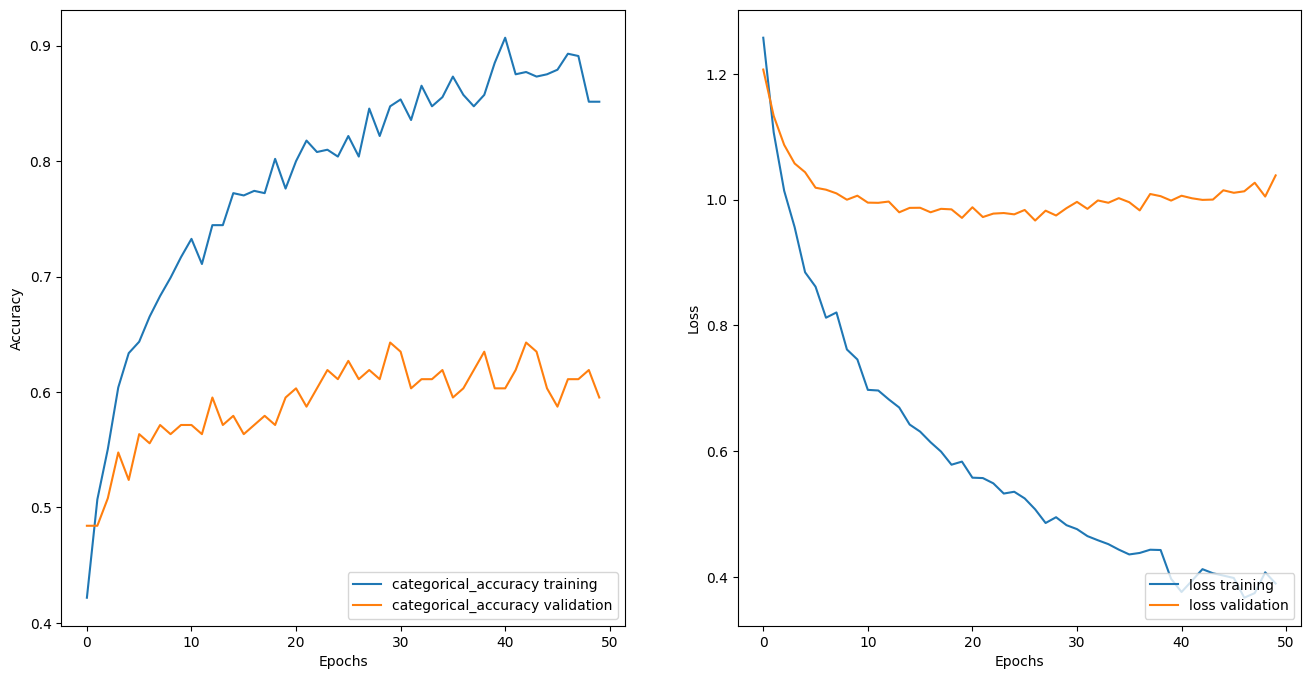

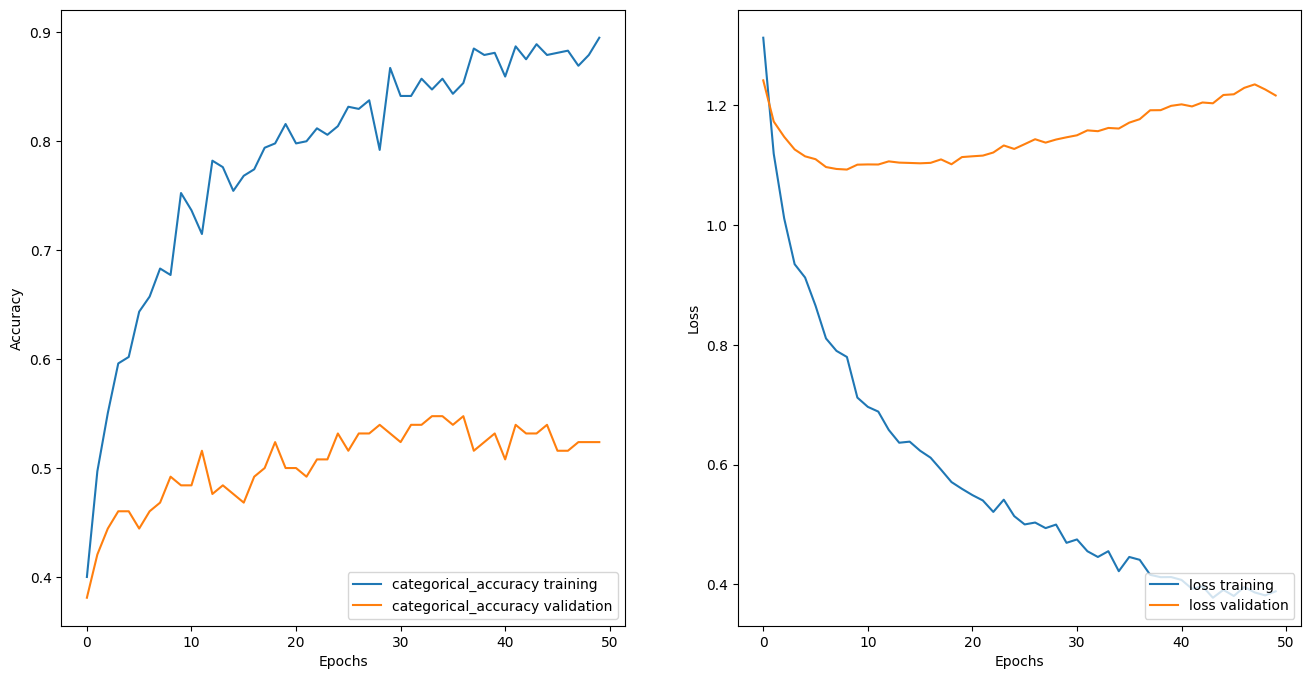

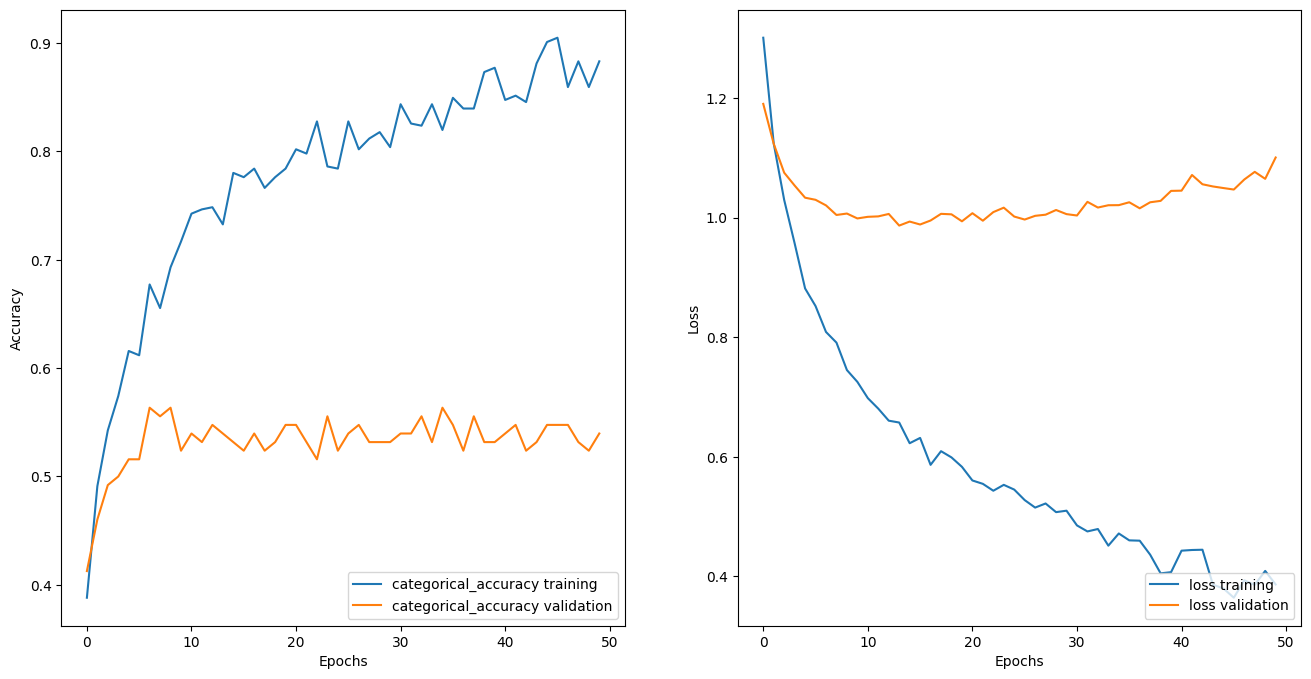

In [36]:
import BodyEmotion4Lib.lib_model as mpp
import matplotlib.pyplot as plt

list_train_index=[];
list_val_index=[];
for train_index, val_index in kf.split(np.zeros(L),Y):
    list_train_index.append(train_index);
    #print('train_index:',train_index);
    list_val_index.append(val_index);
    #print('val_index:',val_index);

data_fold =  {'val_categorical_accuracy': [],'val_loss': [], 'train_categorical_accuracy': [],'train_loss': [] };

fold_var=1;

if os.path.isfile(json_status_path):
    # Read JSON file
    with open(json_status_path) as data_file:
        data_fold = json.load(data_file)
        fold_var=len(data_fold['val_loss'])+1;

while fold_var<=K:
    training_data   = train_val_data.iloc[list_train_index[fold_var-1]]
    validation_data = train_val_data.iloc[list_val_index[fold_var-1]]

    print('\nFold:',fold_var);
    
    # CREATE NEW MODEL
    model, target_size = mpp.create_model(model_type=model_type,load_weights=False);
    model.summary()
    
    train_data_generator = idg.flow_from_dataframe(training_data, 
                                                   directory = dataset_base_dir,
                                                   target_size=target_size,
                                                   x_col = "filename", 
                                                   y_col = "label",
                                                   batch_size=BATCH_SIZE,
                                                   class_mode="categorical",
                                                   shuffle = True);
    
    valid_data_generator  = idg_val.flow_from_dataframe(validation_data, 
                                                    directory = dataset_base_dir,
                                                    target_size=target_size,
                                                    x_col = "filename", 
                                                    y_col = "label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    shuffle = True)
    
    STEPS_BY_EPOCHS=len(train_data_generator);
    

    
    # COMPILE NEW MODEL
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])
    
    # CREATE CALLBACKS
    best_model_file=os.path.join(output_dir,get_model_name(fold_var));
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                    save_weights_only=True,
                                                    monitor='val_loss', 
                                                    save_best_only=True, 
                                                    verbose=1);
    
    log_dir = os.path.join(output_dir,"logs","fit", "fold"+str(fold_var)+'_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"));
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(train_data_generator,
                        steps_per_epoch=STEPS_BY_EPOCHS,
                        epochs=EPOCAS,
                        validation_data=valid_data_generator,
                        callbacks=[checkpoint,tensorboard_callback],
                        verbose=1
                       );
    
    #PLOT HISTORY
    mpp.save_model_history(history,
                           os.path.join(output_dir,"historical_"+str(fold_var)+".csv"),
                           show=False,
                           labels=['categorical_accuracy','loss']);
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(best_model_file);
    
    # Evaluate training
    results = model.evaluate(train_data_generator);
    results = dict(zip(model.metrics_names,results));
    print("Training:\n",results,"\n\n");
    data_fold['train_categorical_accuracy'].append(results['categorical_accuracy']);
    data_fold['train_loss'].append(results['loss']);

    # Evaluate validation
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    print("Validation:\n",results,"\n\n");
    data_fold['val_categorical_accuracy'].append(results['categorical_accuracy'])
    data_fold['val_loss'].append(results['loss'])

    # Data fold
    with open(json_status_path, 'w') as f:
        json.dump(data_fold, f,indent=4);

    tf.keras.backend.clear_session()
    
    fold_var += 1

In [37]:
import json


data_fold['mean_val_categorical_accuracy'] = np.mean(data_fold['val_categorical_accuracy']);
data_fold['std_val_categorical_accuracy']  = np.std(data_fold['val_categorical_accuracy']);

data_fold['mean_val_loss'] = np.mean(data_fold['val_loss']);
data_fold['std_val_loss']  = np.std(data_fold['val_loss']);

data_fold['mean_train_categorical_accuracy'] = np.mean(data_fold['train_categorical_accuracy']);
data_fold['std_train_categorical_accuracy']  = np.std(data_fold['train_categorical_accuracy']);

data_fold['mean_train_loss'] = np.mean(data_fold['train_loss']);
data_fold['std_train_loss']  = np.std(data_fold['train_loss']);

print(data_fold)

# Data fold
with open(json_status_path, 'w') as f:
    json.dump(data_fold, f,indent=4);

{'val_categorical_accuracy': [0.5826771855354309, 0.5317460298538208, 0.6111111044883728, 0.4920634925365448, 0.5396825671195984], 'mean_val_categorical_accuracy': 0.5514560759067535, 'std_val_categorical_accuracy': 0.04144408403011664, 'val_loss': [0.9218157529830933, 1.0506846904754639, 0.9666188359260559, 1.0926847457885742, 0.9866468906402588], 'mean_val_loss': 1.0036901831626892, 'std_val_loss': 0.060822194662344606, 'train_categorical_accuracy': [0.8154761791229248, 0.7801980376243591, 0.8415841460227966, 0.7089108824729919, 0.7643564343452454], 'mean_train_categorical_accuracy': 0.7821051359176636, 'std_train_categorical_accuracy': 0.04544762113999772, 'train_loss': [0.5276528000831604, 0.6092994809150696, 0.48274460434913635, 0.736306369304657, 0.6341067552566528], 'mean_train_loss': 0.5980220019817353, 'std_train_loss': 0.08808241615293136}


In [38]:
fpath=os.path.join(output_dir,"final_stats.m");
mean_val_acc=mpp.save_model_stat_kfold(data_fold['val_categorical_accuracy'],data_fold['val_loss'], fpath);

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats.m'));

print(mean_val_acc)

0.5514560759067535
